# Teaser

This notebook creates a teaser figure for the documentation and paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np
import pandas as pd
import lensed_umap as lu

from umap import UMAP
import matplotlib.pyplot as plt
from matplotlib import colors as cl
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Arc, Ellipse
from matplotlib.collections import PatchCollection, LineCollection

from _plotting import *

configure_matplotlib()
blues = highpassColors()

## Data

The data contains 2D positions and 1 lens dimension.

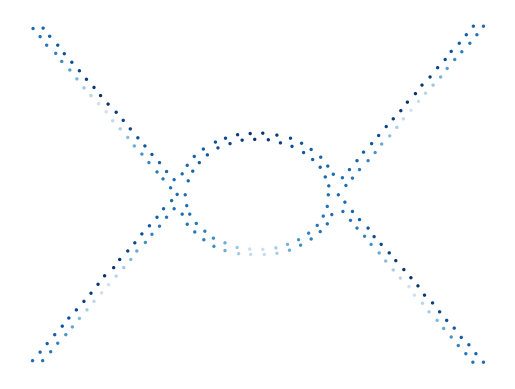

In [3]:
df = pd.read_csv("./data/five_circles.csv", header=0)
lens = np.log(df.hue)

plt.scatter(df.x, df.y, 2, lens, cmap=blues)
plt.axis("off")
plt.show()

## Lenses
Compute the lens-types and store additional info for the figures. 

In [4]:
# Construct UMAP graph
projector = UMAP(repulsion_strength=0.1, negative_sample_rate=2).fit(df[["x", "y"]])
masker = UMAP(n_neighbors=150, repulsion_strength=0.2).fit(df.hue.to_numpy()[None].T)
regular_lensed, regular_bins = lu.apply_lens(
    projector, lens, discretization="regular", resolution=6, ret_bins=True
)
global_masked = lu.apply_mask(projector, masker)
local_masked = lu.apply_local_mask(projector, lens, n_neighbors=6)

## Helpers

Functions that draw common elements.

In [5]:
arc_width = 0.1
local_arc_width = 0.3
keep_arc_color = "k"  # "#6E3C08"
remove_arc_color = "silver"
keep_arc_alpha = 0.3
remove_arc_alpha = 0.05
local_keep_arc_alpha = 1
local_remove_arc_alpha = 0.3

node_size = 6
node_cmap = "RdYlBu"
edge_width = 0.3
edge_alpha = 0.2
edge_color = "k"  # "#6E3C08"

boundary_linetype = ":"
boundary_colour = "k"
boundary_width = 0.5

In [6]:
def draw_nodes(projector, lens, size=None):
    if size is None:
        size = node_size
    x, y = lu.extract_embedding(projector)
    (ix, ax) = x.min(), x.max()
    (iy, ay) = y.min(), y.max()
    plt.scatter(
        (x - ix) / (ax - ix),
        (y - iy) / (ay - iy),
        size,
        lens,
        cmap=node_cmap,
        vmin=lens.min(),
        vmax=lens.max(),
        marker=".",
        edgecolors="none",
        linewidths=0,
    )


def draw_edges(
    projector, edge_width=edge_width, edge_alpha=edge_alpha, edge_color=edge_color
):
    x, y = lu.extract_embedding(projector)
    (ix, ax) = x.min(), x.max()
    (iy, ay) = y.min(), y.max()
    x = (x - ix) / (ax - ix)
    y = (y - iy) / (ay - iy)
    edges = projector.graph_.tocoo()
    parents = edges.row.astype("int")
    children = edges.col.astype("int")
    lc = LineCollection(
        list(zip(zip(x[children], y[children]), zip(x[parents], y[parents]))),
        linewidth=edge_width,
        color=edge_color,
        alpha=edge_alpha,
        zorder=-1,
    )
    plt.gca().add_collection(lc)


def draw_lens(lens, alpha=1):
    plt.scatter(
        lens,
        np.zeros(len(lens)),
        40,
        lens,
        marker="|",
        cmap=node_cmap,
        vmin=lens.min(),
        vmax=lens.max(),
        alpha=alpha,
    )


def draw_boundaries(bins):
    resolution = len(np.unique(bins))
    lower_boundaries = [np.min(lens[bins == b]) for b in range(resolution)]
    upper_boundaries = [np.max(lens[bins == b]) for b in range(resolution)]
    boundaries = [
        (l + u) / 2 for l, u in zip(lower_boundaries[1:], upper_boundaries[:-1])
    ]
    for b in boundaries:
        plt.plot(
            [b, b],
            [-0.15, 0.5],
            boundary_linetype,
            color=boundary_colour,
            linewidth=boundary_width,
        )


def draw_arcs_for_point(projector, lens, idx, n_neighbors=None):
    start_idx = projector.graph_.indptr[idx]
    end_idx = projector.graph_.indptr[idx + 1]
    columns = projector.graph_.indices[start_idx:end_idx]
    distances = np.abs(lens[idx] - lens[columns])
    columns = columns[np.argsort(distances)]
    if n_neighbors is None:
        n_neighbors = len(columns)
    plt.text(
        lens[idx] - 0.03,
        -0.07,
        "$\\uparrow$ per point",
        va="top",
        ha="left",
        fontsize=8,
    )
    plt.gca().add_collection(
        PatchCollection(
            [
                Arc(
                    [(lens[idx] + lens[columns[i]]) / 2, 0.1],
                    abs(lens[idx] - lens[columns[i]]),
                    abs(lens[idx] - lens[columns[i]]) / 3.5,
                    theta2=180.0,
                    alpha=local_remove_arc_alpha,
                    color=remove_arc_color,
                    linewidth=local_arc_width,
                )
                for i in range(n_neighbors, len(columns))
            ],
            match_original=True,
        )
    )
    plt.gca().add_collection(
        PatchCollection(
            [
                Arc(
                    [(lens[idx] + lens[columns[i]]) / 2, 0.1],
                    abs(lens[idx] - lens[columns[i]]),
                    abs(lens[idx] - lens[columns[i]]) / 3.5,
                    theta2=180.0,
                    alpha=local_keep_arc_alpha,
                    color=keep_arc_color,
                    linewidth=local_arc_width,
                )
                for i in range(n_neighbors)
            ],
            match_original=True,
        )
    )


def draw_filtered_arcs(projector, result, lens, flipped=False):
    g1 = projector.graph_.copy()
    g1.data[:] = 1
    g2 = result.graph_.copy()
    g2.data[:] = 1

    remove_edges = g1 - g2
    remove_edges.eliminate_zeros()
    keep_edges = g1 - remove_edges
    keep_edges.eliminate_zeros()

    projector_keep = []
    projector_remove = []

    direction = 1 - (flipped * 2)

    for row in range(len(lens)):
        start_idx = remove_edges.indptr[row]
        end_idx = remove_edges.indptr[row + 1]
        for col in remove_edges.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            projector_remove.append(
                Arc(
                    [(lens[row] + lens[col]) / 2, direction * 0.1],
                    2 * radius,
                    direction * radius,
                    theta2=180.0,
                    alpha=remove_arc_alpha,
                    color=remove_arc_color,
                    linewidth=arc_width,
                )
            )

        start_idx = keep_edges.indptr[row]
        end_idx = keep_edges.indptr[row + 1]
        for col in keep_edges.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            projector_keep.append(
                Arc(
                    [(lens[row] + lens[col]) / 2, direction * 0.1],
                    2 * radius,
                    direction * min(radius, 0.49),
                    theta2=180.0,
                    alpha=keep_arc_alpha,
                    color=keep_arc_color,
                    linewidth=arc_width,
                )
            )

    plt.gca().add_collection(PatchCollection(projector_remove, match_original=True))
    plt.gca().add_collection(PatchCollection(projector_keep, match_original=True))


def draw_arcs(
    projector, lens, flipped=False, arc_width=arc_width, arc_alpha=keep_arc_alpha
):
    projector_keep = []
    direction = 1 - (flipped * 2)
    for row in range(len(lens)):
        start_idx = projector.graph_.indptr[row]
        end_idx = projector.graph_.indptr[row + 1]
        for col in projector.graph_.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            projector_keep.append(
                Arc(
                    [(lens[row] + lens[col]) / 2, direction * 0.1],
                    2 * radius,
                    direction * min(radius, 0.49),
                    theta2=180.0,
                    alpha=arc_alpha,
                    color=keep_arc_color,
                    linewidth=arc_width,
                )
            )
    plt.gca().add_collection(PatchCollection(projector_keep, match_original=True))

## Draw
The code that draws the figure:

In [44]:
width = 2.25795 # inch as shown in latex
height = width / 9 * 16
title_width = 0.4 * 2.65215 # Same as in air_quality dataset!
top = 0.93

### Global lens

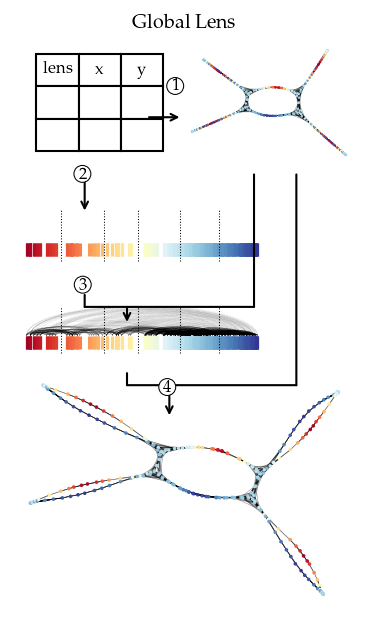

In [47]:
fig = plt.figure(figsize=(width, height), dpi=150)
gs = fig.add_gridspec(5, 4, height_ratios=[2, 1, 1, 1, 4])

fig.add_subplot(gs[0, :2])
plt.table(
    colLabels=["lens", "x", "y"],
    cellText=[
        ["", "", ""],
        ["", "", ""],
    ],
    loc="center",
    colWidths=[0.25] * 3,
).set_fontsize(8)
frame_off()

fig.add_subplot(gs[0, 2:])
draw_nodes(projector, lens)
draw_edges(projector)
xlim = plt.xlim()
ylim = plt.ylim()
frame_off()

fig.add_subplot(gs[1:3, :3])
plt.ylim(-0.6, 1)
draw_lens(lens)
draw_boundaries(regular_bins)
frame_off()

fig.add_subplot(gs[3, :3])
plt.ylim(-0.3, 0.5)
draw_lens(lens)
draw_boundaries(regular_bins)
draw_filtered_arcs(projector, regular_lensed, lens)
frame_off()

fig.add_subplot(gs[4, ::])
draw_nodes(regular_lensed, lens, size=12)
draw_edges(regular_lensed)
plt.xlim(xlim)
plt.ylim(ylim)
frame_off()

plt.subplots_adjust(0, 0, 1, top, hspace=0.1, wspace=0)
plt.suptitle("Global Lens", fontsize=9.5)
# fig.add_artist(Line2D(
#     [0.05 / width, 0.5 - title_width / 2 / width], [0.9665, 0.9665], 
#     lw=0.5, color='k', transform=fig.transFigure
# ))
# fig.add_artist(Line2D(
#     [0.5 + title_width / 2 / width, 1], [0.9665, 0.9665], 
#     lw=0.5, color='k', transform=fig.transFigure
# ))

arrows = [
    ((0.53, 0.835), (0.44, 0.835)),
    ((0.25, 0.68), (0.25, 0.74)),
    # ((0.25, 0.61), (0.25, 0.645)),
    ((0.375, 0.495), (0.375, 0.52)),
    ((0.5, 0.34), (0.5, 0.39)),
]
for begin, end in arrows:
    plt.annotate(
        "",
        begin,
        end,
        arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0),
        xycoords="figure fraction",
    )

arrows = [
    ((0.25, 0.52), (0.25, 0.54)),
    ((0.75, 0.52), (0.75, 0.74)),
    ((0.25, 0.52), (0.75, 0.52)),
    ((0.375, 0.39), (0.375, 0.41)),
    ((0.875, 0.39), (0.875, 0.74)),
    ((0.375, 0.39), (0.875, 0.39)),
]
for begin, end in arrows:
    plt.annotate(
        "",
        begin,
        end,
        arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0),
        xycoords="figure fraction",
    )

numbers = [
    (0.475, 0.86),
    (0.20, 0.714),
    (0.20, 0.53),
    (0.45, 0.36),
]
x_offsets = [-0.002, -0.001, 0, -0.0005]
y_offsets = [0.002, 0.002, 0.002, 0.002]
for i, ((x, y), o_x, o_y) in enumerate(zip(numbers, x_offsets, y_offsets)):
    fig.patches.append(
        Ellipse(
            (x + o_x, y + o_y),
            width=0.05,
            height=0.05 / height * width,
            linewidth=0.5,
            edgecolor="k",
            facecolor="w",
            transform=fig.transFigure,
        )
    )
    fig.text(
        x,
        y,
        f"{i + 1}",
        color="k",
        fontsize=8,
        va="center",
        ha="center",
        transform=fig.transFigure,
    )


plt.savefig("./figures/teaser_global_lens.png", dpi=600, pad_inches=0)
plt.show()

### Global mask

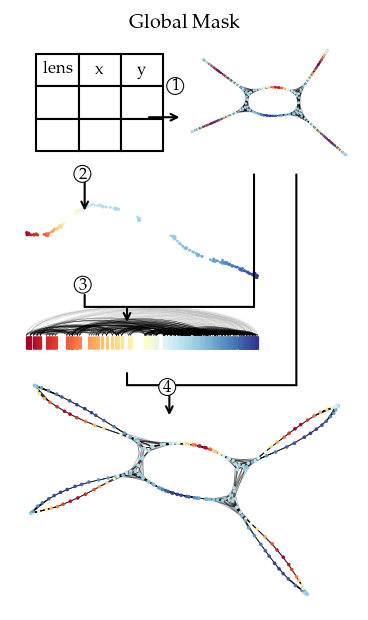

In [48]:
fig = plt.figure(figsize=(width, height), dpi=150)
gs = fig.add_gridspec(5, 4, height_ratios=[2, 1, 1, 1, 4])

fig.add_subplot(gs[0, :2])
plt.table(
    colLabels=["lens", "x", "y"],
    cellText=[
        ["", "", ""],
        ["", "", ""],
    ],
    loc='center',
    colWidths=[0.25] * 3
).set_fontsize(8)
frame_off()

fig.add_subplot(gs[0, 2:])
draw_nodes(projector, lens)
draw_edges(projector)
xlim = plt.xlim()
ylim = plt.ylim()
frame_off()

fig.add_subplot(gs[1:3, :3])
draw_nodes(masker, lens)
draw_edges(masker, edge_width=0.03, edge_alpha=0.01)
ylim = plt.ylim()
plt.ylim(ylim[0] - 0.2, ylim[1] + 0.4)
frame_off()


fig.add_subplot(gs[3, :3])
plt.ylim(-0.3, 0.5)
draw_lens(lens)
draw_filtered_arcs(projector, global_masked, lens)
frame_off()

fig.add_subplot(gs[4, ::])
draw_nodes(global_masked, lens, size=12)
draw_edges(global_masked)
plt.xlim(xlim)
plt.ylim(ylim)
frame_off()

plt.subplots_adjust(0, 0, 1, top, hspace=0.1, wspace=0)
plt.suptitle('Global Mask', fontsize=9.5)
# fig.add_artist(Line2D(
#     [0.05 / width, 0.5 - title_width / 2 / width], [0.9665, 0.9665], 
#     lw=0.5, color='k', transform=fig.transFigure
# ))
# fig.add_artist(Line2D(
#     [0.5 + title_width / 2 / width, 1], [0.9665, 0.9665], 
#     lw=0.5, color='k', transform=fig.transFigure
# ))

arrows = [
    ((0.53, 0.835), (0.44, 0.835)),
    ((0.25, 0.68), (0.25, 0.74)),
    ((0.375, 0.495), (0.375, 0.52)),
    ((0.5, 0.34), (0.5, 0.39))
]
for begin, end in arrows:
    plt.annotate(
        "",
        begin,
        end,
        arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0),
        xycoords="figure fraction",
    )

arrows = [
    ((0.25, 0.52), (0.25, 0.54)),
    ((0.75, 0.52), (0.75, 0.74)),
    ((0.25, 0.52), (0.75, 0.52)),
    ((0.375, 0.39), (0.375, 0.41)),
    ((0.875, 0.39), (0.875, 0.74)),
    ((0.375, 0.39), (0.875, 0.39)),
]
for begin, end in arrows:
    plt.annotate(
        "",
        begin,
        end,
        arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0),
        xycoords="figure fraction",
    )

numbers = [
    (0.475, 0.86), 
    (0.20, 0.714),
    (0.20, 0.53),
    (0.45, 0.36),
]
x_offsets = [-0.002, -0.001, 0, -0.0005]
y_offsets = [0.002, 0.002, 0.002, 0.002]
for i, ((x, y), o_x, o_y) in enumerate(zip(numbers, x_offsets, y_offsets)):
    fig.patches.append(Ellipse(
        (x + o_x, y + o_y), 
        width=0.05, 
        height=0.05 / height * width, 
        linewidth=0.5,
        edgecolor="k",
        facecolor="w",
        transform=fig.transFigure,
    ))
    fig.text(
        x, y, f'{i + 1}', 
        color='k',
        fontsize=8, 
        va='center', 
        ha='center', 
        transform=fig.transFigure, 
    )


plt.savefig('./figures/teaser_global_mask.png', dpi=600, pad_inches=0)
plt.show()

### Local Mask

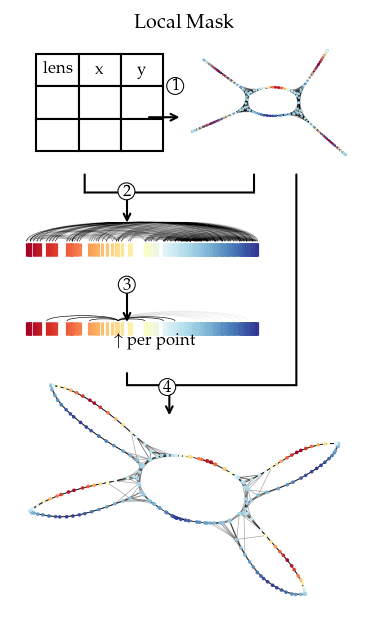

In [50]:
fig = plt.figure(figsize=(width, height), dpi=150)
gs = fig.add_gridspec(5, 4, height_ratios=[2, 1, 1, 1, 4])

fig.add_subplot(gs[0, :2])
plt.table(
    colLabels=["lens", "x", "y"],
    cellText=[
        ["", "", ""],
        ["", "", ""],
    ],
    loc='center',
    colWidths=[0.25] * 3
).set_fontsize(8)
frame_off()

fig.add_subplot(gs[0, 2:])
draw_nodes(projector, lens)
draw_edges(projector)
xlim = plt.xlim()
ylim = plt.ylim()
frame_off()

fig.add_subplot(gs[1:3, :3])
plt.ylim(-0.6, 1)
draw_lens(lens)
draw_arcs(projector, lens, arc_width=0.07, arc_alpha=0.1)
frame_off()


fig.add_subplot(gs[3, :3])
plt.ylim(-0.5, 0.3)
draw_lens(lens)
draw_arcs_for_point(projector, lens, np.argpartition(lens, 45)[45], n_neighbors=6)
frame_off()


fig.add_subplot(gs[4, ::])
draw_nodes(local_masked, lens, size=12)
draw_edges(local_masked)
plt.xlim(xlim)
plt.ylim(ylim)
frame_off()

plt.subplots_adjust(0, 0, 1, top, hspace=0.1, wspace=0)
plt.suptitle('Local Mask', fontsize=9.5)
# fig.add_artist(Line2D(
#     [0.05 / width, 0.5 - title_width / 2 / width], [0.9665, 0.9665], 
#     lw=0.5, color='k', transform=fig.transFigure
# ))
# fig.add_artist(Line2D(
#     [0.5 + title_width / 2 / width, 1], [0.9665, 0.9665], 
#     lw=0.5, color='k', transform=fig.transFigure
# ))

arrows = [
    ((0.53, 0.835), (0.44, 0.835)),
    ((0.375, 0.66), (0.375, 0.71)),
    ((0.375, 0.495), (0.375, 0.56)),
    ((0.5, 0.34), (0.5, 0.39))
]
for begin, end in arrows:
    plt.annotate(
        "",
        begin,
        end,
        arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0),
        xycoords="figure fraction",
    )

arrows = [
    ((0.25, 0.71), (0.25, 0.74)),
    ((0.75, 0.71), (0.75, 0.74)),
    ((0.25, 0.71), (0.75, 0.71)),
    ((0.375, 0.39), (0.375, 0.41)),
    ((0.875, 0.39), (0.875, 0.74)),
    ((0.375, 0.39), (0.875, 0.39)),
]
for begin, end in arrows:
    plt.annotate(
        "",
        begin,
        end,
        arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0),
        xycoords="figure fraction",
    )

numbers = [
    (0.475, 0.86), 
    (0.33, 0.685),
    (0.33, 0.53),
    (0.45, 0.36),
]
x_offsets = [-0.002, -0.001, 0, -0.0005]
y_offsets = [0.002, 0.002, 0.002, 0.002]
for i, ((x, y), o_x, o_y) in enumerate(zip(numbers, x_offsets, y_offsets)):
    fig.patches.append(Ellipse(
        (x + o_x, y + o_y), 
        width=0.05, 
        height=0.05 / height * width, 
        linewidth=0.5,
        edgecolor="k",
        facecolor="w",
        transform=fig.transFigure,
    ))
    fig.text(
        x, y, f'{i + 1}', 
        color='k',
        fontsize=8, 
        va='center', 
        ha='center', 
        transform=fig.transFigure, 
    )


plt.savefig('./figures/teaser_local_mask.png', dpi=600, pad_inches=0)
plt.show()